In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Embedding CPLEX in a ML Spark Pipeline
`Spark ML` provides a uniform set of high-level APIs that help users create and tune practical machine learning pipelines.

In this notebook, we show how to embed CPLEX as a Spark _transformer_ class.
DOcplex provides transformer classes that take a matrix `X` of constraints and a vector `y` of costs and solves a linear problem using CPLEX.

Transformer classes share a `solve(X, Y, **params)` method which expects:
 - an X matrix containing the constraints of the linear problem
 - a Y vector containing the cost coefficients.
 
The transformer classes requires a Spark DataFrame for the 'X' matrix, and support various formats for the 'Y' vector:

- Python lists,
- numpy vector,
- pandas Series,
- Spark columns

The same formats are also supported to optionally specify upper bounds for decision variables.

 
## DOcplex transformer classes

There are two DOcplex transformer classes:

 - __$CplexTransformer$__ expects to solve a linear problem in the classical form: 
 
 $$ minimize\  C^{t} x\\ s.t.\\ 
 Ax <= B$$
 
 Where $A$ is a (M,N) matrix describing the constraints and $B$ is a scalar vector of size M, containing the _right hand sides_ of the constraints, and $C$ is the _cost vector_ of size N. In this case the transformer expects a (M,N+1) matrix, where the last column contains the right hand sides.
 
 - __$CplexRangeTransformer$__ expects to solve linear problem as a set of _range_ constraints:
 
  $$ minimize\  C^{t} x\\ s.t.\\ 
 m <= Ax <= M$$
 
  Where $A$ is a (M,N) matrix describing the constraints, $m$ and $M$ are two scalar vectors of size M, containing the _minimum_ and _maximum_ values for the row expressions, and $C$ is the _cost vector_ of size N. In this case the transformer expects a (M,N+2) matrix, where the last two columns contains the minimum and maximum values (in this order).


In [2]:
try:
    import numpy as np
except ImportError:
    raise RuntimError('This notebook requires numpy')


In the next section we illustrate the range transformer with the Diet Problem, from DOcplex distributed examples.


## The Diet Problem

The diet problem is delivered in the DOcplex examples.

Given a breakdown matrix of various foods in elementary nutrients, plus limitations on quantities for foods an nutrients, and food costs, the goal is to find the optimal quantity for each food for a balanced diet.

The __FOOD_NUTRIENTS__ data intentionally contains a missing value ($np.nan$) to illustrate the use of a pipeline involving a data cleansing stage.

In [3]:
# the baseline diet data as Python lists of tuples.
FOODS = [
    ("Roasted Chicken", 0.84, 0, 10),
    ("Spaghetti W/ Sauce", 0.78, 0, 10),
    ("Tomato,Red,Ripe,Raw", 0.27, 0, 10),
    ("Apple,Raw,W/Skin", .24, 0, 10),
    ("Grapes", 0.32, 0, 10),
    ("Chocolate Chip Cookies", 0.03, 0, 10),
    ("Lowfat Milk", 0.23, 0, 10),
    ("Raisin Brn", 0.34, 0, 10),
    ("Hotdog", 0.31, 0, 10)
]

NUTRIENTS = [
    ("Calories", 2000, 2500),
    ("Calcium", 800, 1600),
    ("Iron", 10, 30),
    ("Vit_A", 5000, 50000),
    ("Dietary_Fiber", 25, 100),
    ("Carbohydrates", 0, 300),
    ("Protein", 50, 100)
]

FOOD_NUTRIENTS = [
    ("Roasted Chicken", 277.4, 21.9, 1.8, 77.4, 0.0, 0.0, 42.2),
    ("Spaghetti W/ Sauce", 358.2, 80.2, 2.3, 3055.2, 11.6, 58.3, 8.2),
    ("Tomato,Red,Ripe,Raw", 25.8, 6.2, 0.6, 766.3, 1.4, 5.7, 1.0),
    ("Apple,Raw,W/Skin", 81.4, 9.7, 0.2, 73.1, 3.7, 21.0, 0.3),
    ("Grapes", 15.1, 3.4, 0.1, 24.0, 0.2, 4.1, 0.2),
    ("Chocolate Chip Cookies", 78.1, 6.2, 0.4, 101.8, 0.0, 9.3, 0.9),
    ("Lowfat Milk", 121.2, 296.7, 0.1, 500.2, 0.0, 11.7, 8.1),
    ("Raisin Brn", 115.1, 12.9, 16.8, 1250.2, 4.0, 27.9, 4.0),
    ("Hotdog", 242.1, 23.5, 2.3, 0.0, 0.0, 18.0, 10.4)
]

In [4]:
nb_foods = len(FOODS)
nb_nutrients = len(NUTRIENTS)
print('#foods={0}'.format(nb_foods))
print('#nutrients={0}'.format(nb_nutrients))

assert nb_foods == len(FOOD_NUTRIENTS)

#foods=9
#nutrients=7


### Creating a Spark session

In [5]:
try:
    import findspark
    findspark.init()
except ImportError:
    # Ignore exception: the 'findspark' module is required when executing Spark in a Windows environment
    pass

import pyspark  # Only run after findspark.init() (if running in a Windows environment)
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

## Using the transformer with a Spark dataframe

In this section we show how to use a transformer with data stored in a Spark dataframe.

### Prepare the data as a numpy matrix

In this section we build a numpy matrix to be passed to the transformer.

First, we extract the food to nutrient matrix by stripping the names.

In [6]:
mat_fn = np.matrix([FOOD_NUTRIENTS[f][1:] for f in range(nb_foods)])
print('The food-nutrient matrix has shape: {0}'.format(mat_fn.shape))

The food-nutrient matrix has shape: (9L, 7L)


Then we extract the two vectors of min/max for each nutrient. Each vector has nb_nutrients elements.
We also break the `FOODS` collection of tuples into columns

In [7]:
nutrient_mins = [NUTRIENTS[n][1] for n in range(nb_nutrients)]
nutrient_maxs = [NUTRIENTS[n][2] for n in range(nb_nutrients)]

food_names ,food_costs, food_mins, food_maxs = map(list, zip(*FOODS))

We are now ready to prepare the transformer matrix. This matrix has shape (7, 11) as we
have 7 nutrients and 9 foods, plus the additional `min` and `max` columns

In [8]:
# step 1. add two lines for nutrient mins, maxs
nf2 = np.append(mat_fn, np.matrix([nutrient_mins, nutrient_maxs]), axis=0)
mat_nf = nf2.transpose()

In [9]:
mat_nf.shape

(7L, 11L)

### Populate a Spark dataframe with the matrix data

In this section we build a Spark dataframe matrix to be passed to the transformer.

Using a Spark dataframe will also allow us to chain multiple transformers in a pipeline.

In [10]:
from pyspark.sql import SQLContext

sc = spark.sparkContext
sqlContext = SQLContext(sc)

columns = food_names + ['min', 'max']
food_nutrients_df = sqlContext.createDataFrame(mat_nf.tolist(), columns)

Let's display the dataframe schema and content

In [11]:
food_nutrients_df.printSchema()

root
 |-- Roasted Chicken: double (nullable = true)
 |-- Spaghetti W/ Sauce: double (nullable = true)
 |-- Tomato,Red,Ripe,Raw: double (nullable = true)
 |-- Apple,Raw,W/Skin: double (nullable = true)
 |-- Grapes: double (nullable = true)
 |-- Chocolate Chip Cookies: double (nullable = true)
 |-- Lowfat Milk: double (nullable = true)
 |-- Raisin Brn: double (nullable = true)
 |-- Hotdog: double (nullable = true)
 |-- min: double (nullable = true)
 |-- max: double (nullable = true)



In [12]:
food_nutrients_df.show()

+---------------+------------------+-------------------+----------------+------+----------------------+-----------+----------+------+------+-------+
|Roasted Chicken|Spaghetti W/ Sauce|Tomato,Red,Ripe,Raw|Apple,Raw,W/Skin|Grapes|Chocolate Chip Cookies|Lowfat Milk|Raisin Brn|Hotdog|   min|    max|
+---------------+------------------+-------------------+----------------+------+----------------------+-----------+----------+------+------+-------+
|          277.4|             358.2|               25.8|            81.4|  15.1|                  78.1|      121.2|     115.1| 242.1|2000.0| 2500.0|
|           21.9|              80.2|                6.2|             9.7|   3.4|                   6.2|      296.7|      12.9|  23.5| 800.0| 1600.0|
|            1.8|               2.3|                0.6|             0.2|   0.1|                   0.4|        0.1|      16.8|   2.3|  10.0|   30.0|
|           77.4|            3055.2|              766.3|            73.1|  24.0|                 101.8|   

### Solving the Diet problem with the $CplexRangeTransformer$ in a Pipeline

To use the transformer, create an instance and pass the following parameters to the `transform` method
 - the `X` matrix of size(M, N+2) containing coefficients for N column variables plus two addition column for range mins and maxs.
 - the `Y` cost vector (using __"y"__ parameter id)
 - whether one wants to solve a minimization (`min`) or maximization (`max`) problem (using __"sense"__ parameter id)
 
In addition, some data elements that can't be encoded in the matrix itself should be passed as keyword arguments:

- `ubs` denotes the upper bound for the column variables that are created. The expected size of this scalar vector is N (when matrix has size (M,N+2))
- `minCol` and `maxCol` are the names of the columns corresponding to the constraints min and max range in the `X` matrix

In [13]:
from docplex.mp.sparktrans.transformers import CplexRangeTransformer
from pyspark.ml import Pipeline
from pyspark.sql.functions import *

# Create the optimization transformer to calculate the optimal quantity for each food for a balanced diet.
cplexSolve = CplexRangeTransformer(minCol='min', maxCol='max', ubs=food_maxs)

# Make evaluation on input data. Additional parameters are specified using the 'params' dictionary
diet_df = cplexSolve.transform(food_nutrients_df, params={cplexSolve.y: food_costs, cplexSolve.sense: 'min'})
diet_df.orderBy(desc("value")).show()

+--------------------+------------------+
|                name|             value|
+--------------------+------------------+
|Chocolate Chip Co...|              10.0|
|  Spaghetti W/ Sauce|2.1551724137931036|
|         Lowfat Milk|1.8311671008899093|
|              Hotdog|0.9296975991385928|
|    Apple,Raw,W/Skin|               0.0|
|          Raisin Brn|               0.0|
|     Roasted Chicken|               0.0|
| Tomato,Red,Ripe,Raw|               0.0|
|              Grapes|               0.0|
+--------------------+------------------+



### Example with CplexTransformer

To illustrate the usage of the __$CplexTransformer$__, let's remove the constraint on the minimum amount for nutrients, and reformulate the problem as a cost maximization.

First, let's define a new dataframe for the constraints matrix by removing the `min` column from the `food_nutrients_df` dataframe so that it is a well-formed input matrix for the __$CplexTransformer$__:

In [14]:
food_nutrients_LP_df = food_nutrients_df.select([item for item in food_nutrients_df.columns if item not in ['min']])
food_nutrients_LP_df.show()

+---------------+------------------+-------------------+----------------+------+----------------------+-----------+----------+------+-------+
|Roasted Chicken|Spaghetti W/ Sauce|Tomato,Red,Ripe,Raw|Apple,Raw,W/Skin|Grapes|Chocolate Chip Cookies|Lowfat Milk|Raisin Brn|Hotdog|    max|
+---------------+------------------+-------------------+----------------+------+----------------------+-----------+----------+------+-------+
|          277.4|             358.2|               25.8|            81.4|  15.1|                  78.1|      121.2|     115.1| 242.1| 2500.0|
|           21.9|              80.2|                6.2|             9.7|   3.4|                   6.2|      296.7|      12.9|  23.5| 1600.0|
|            1.8|               2.3|                0.6|             0.2|   0.1|                   0.4|        0.1|      16.8|   2.3|   30.0|
|           77.4|            3055.2|              766.3|            73.1|  24.0|                 101.8|      500.2|    1250.2|   0.0|50000.0|
|     

In [15]:
from docplex.mp.sparktrans.transformers import CplexTransformer

# Create the optimization transformer to calculate the optimal quantity for each food for a balanced diet.
# Here, let's use the CplexTransformer by specifying only a maximum amount for each nutrient.
cplexSolve = CplexTransformer(rhsCol='max', ubs=food_maxs)

# Make evaluation on input data. Additional parameters are specified using the 'params' dictionary
# Since there is no lower range for decision variables, let's maximize cost instead! (otherwise, the result is all 0's)
diet_max_cost_df = cplexSolve.transform(food_nutrients_LP_df, params={cplexSolve.y: food_costs, cplexSolve.sense: 'max'})
diet_max_cost_df.orderBy(desc("value")).show()

-- all numbers will be cast to float
+--------------------+------------------+
|                name|             value|
+--------------------+------------------+
| Tomato,Red,Ripe,Raw|              10.0|
|              Grapes|              10.0|
|    Apple,Raw,W/Skin| 9.619047619047619|
|     Roasted Chicken|2.0169262017603247|
|  Spaghetti W/ Sauce|               0.0|
|              Hotdog|               0.0|
|         Lowfat Milk|               0.0|
|Chocolate Chip Co...|               0.0|
|          Raisin Brn|               0.0|
+--------------------+------------------+



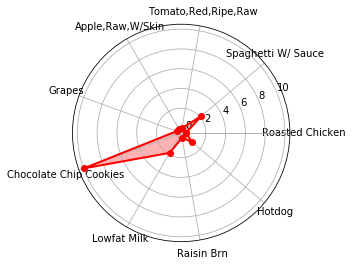

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_radar_chart(labels, stats, **kwargs):
    angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    # close the plot
    stats  = np.concatenate((stats, [stats[0]]))
    angles = np.concatenate((angles, [angles[0]]))
    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=2, **kwargs)
    ax.fill(angles, stats, alpha=0.30, **kwargs)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    #ax.set_title([df.loc[386,"Name"]])
    ax.grid(True)
    
diet = diet_df.toPandas()
plot_radar_chart(labels=diet['name'], stats=diet['value'], color='r')

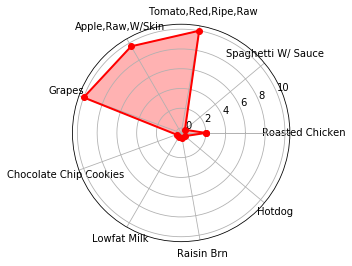

In [17]:
diet_max_cost = diet_max_cost_df.toPandas()
plot_radar_chart(labels=diet_max_cost['name'], stats=diet_max_cost['value'], color='r')